In [ ]:
# Importation des libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
import plotly.graph_objs as go
from plotly.offline import iplot

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler




#Importation des données

In [ ]:
# Importation de la serie chronologique
ticker = "GOOGL"
data = yf.download(ticker, start="2020-04-01", end="2023-04-01")

# Stocker les données dans un DataFrame Pandas
df = pd.DataFrame(data)

# Afficher les cinq premières lignes du DataFrame
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,56.200001,56.471001,54.674500,55.105000,55.105000,51970000
2020-04-02,55.000000,56.138500,54.656502,55.851501,55.851501,56410000
2020-04-03,55.735500,55.939499,53.754002,54.634998,54.634998,51374000
2020-04-06,56.650002,59.537498,56.250000,59.159500,59.159500,63320000
2020-04-07,60.850498,61.039001,58.862499,59.127998,59.127998,61620000


# Visualisation de la Serie chronologique


In [ ]:
# Assurer que l'index est une colonne 'Date'
df.reset_index(inplace=True)

# Définir la fonction pour tracer le graphe
def plot_dataset(df, title):
    data = []

    value = go.Scatter(
        x=df['Date'],
        y=df['Close'],
        mode="lines",
        name="Close",
        marker=dict(),
        text=df['Date'],
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False, showgrid=True),
        yaxis=dict(title="Close", ticklen=5, zeroline=False),
        showlegend=True
    )

    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

# Utiliser la fonction plot_dataset avec vos données AAPL
plot_dataset(df, title='Graphique GOOGL via yfinance')


#Prétraitement des données

### Division de la data en ensembles d'entraînement et de test.

In [ ]:
# Sélectionner les prix de clôture
close_prices = data['Close'].values.reshape(-1, 1)

TRAIN_data, TEST_data = train_test_split(close_prices, test_size=0.2, shuffle=False)

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(TRAIN_data)
test_data = scaler.fit_transform(TEST_data)
train_data.shape, test_data.shape

((604, 1), (152, 1))

In [ ]:
TRAIN_date, TEST_date = train_test_split(data.index, test_size=0.2, shuffle=False)
TRAIN_date.shape, TEST_date.shape

((604,), (152,))

### préparation des séquences de données temporelles

In [ ]:
def prepare_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 50  # Nombre d'étapes temporelles pour chaque échantillon
X_train, y_train = prepare_sequences(train_data, n_steps)
X_test, y_test = prepare_sequences(test_data, n_steps)

### Remodelage des données pour l'entrée du modèle RNN

In [ ]:
# Remodeler les données pour les rendre compatibles avec l'entrée du modèle RNN
X_train, y_train = np.array(X_train), np.array(y_train)
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


X_test, y_test = np.array(X_test), np.array(y_test)
#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)



X_train : (554, 50, 1) y_train : (554, 1)
X_test : (102, 50, 1) y_test : (102, 1)


# SimpleRNN Model

In [ ]:
#Construction du modèle RNN
regressor = Sequential()

## Définition de l'architecture du modele RNN
regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True,
						input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add(SimpleRNN(units = 50,
						activation = "tanh",
						return_sequences = True))

regressor.add( SimpleRNN(units = 50))

regressor.add(Dense(units = 1,activation='sigmoid'))

## Compilation du modèle RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
								momentum=0.9,
								nesterov=True),
				loss = "mean_squared_error")

regressor.fit(X_train, y_train, epochs = 5, batch_size = 2)
regressor.summary()


Epoch 1/5
277/277 [==============================] - 9s 22ms/step - loss: 0.0281
Epoch 2/5
277/277 [==============================] - 6s 20ms/step - loss: 0.0067
Epoch 3/5
277/277 [==============================] - 6s 21ms/step - loss: 0.0050
Epoch 4/5
277/277 [==============================] - 6s 21ms/step - loss: 0.0043
Epoch 5/5
277/277 [==============================] - 6s 21ms/step - loss: 0.0046
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)    

 ## Validation du modele

In [ ]:
loss = regressor.evaluate(X_test, y_test)
print(f'Loss: {loss}')


4/4 [==============================] - 0s 8ms/step - loss: 0.0255
Loss: 0.025505589321255684


# Utilisation du modele RNN pour la prediction

In [ ]:
y_RNN = regressor.predict(X_test)
y_RNN_O = scaler.inverse_transform(y_RNN)

4/4 [==============================] - 0s 8ms/step


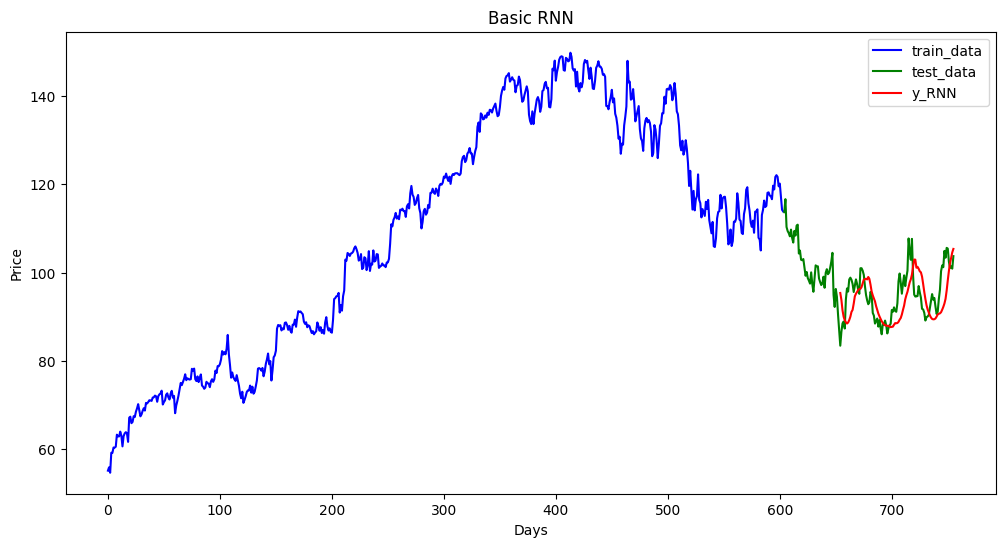

In [ ]:
plt.figure(figsize=(12, 6))

# Premier graphique pour Basic RNN
plt.plot(TRAIN_date, TRAIN_data, label="train_data", color="b")
plt.plot(TEST_date, TEST_data, label="test_data", color="g")
plt.plot(TEST_date[50:], y_RNN_O, label="y_RNN", color="r")

plt.legend()
plt.title("Basic RNN")
plt.xlabel("Days")
plt.ylabel("Price")

plt.show()

#LSTM Model

In [ ]:
#Construction du modèle LSTM
regressorLSTM = Sequential()

## Définition de l'architecture du modele LSTM
regressorLSTM.add(LSTM(50,
					return_sequences = True,
					input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50,
					return_sequences = False))
regressorLSTM.add(Dense(25))

regressorLSTM.add(Dense(1))

## Compilation du modele LSTM
regressorLSTM.compile(optimizer = 'adam',
					loss = 'mean_squared_error',
					metrics = ["accuracy"])

regressorLSTM.fit(X_train,
				y_train,
				batch_size = 1,
				epochs = 5)
regressorLSTM.summary()


Epoch 1/5
554/554 [==============================] - 13s 15ms/step - loss: 0.0064 - accuracy: 0.0018
Epoch 2/5
554/554 [==============================] - 8s 15ms/step - loss: 0.0022 - accuracy: 0.0018
Epoch 3/5
554/554 [==============================] - 8s 15ms/step - loss: 0.0018 - accuracy: 0.0018
Epoch 4/5
554/554 [==============================] - 8s 15ms/step - loss: 0.0017 - accuracy: 0.0018
Epoch 5/5
554/554 [==============================] - 8s 15ms/step - loss: 0.0014 - accuracy: 0.0018
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
               

##  Validation du modele LSTM

In [ ]:
lossLSTM = regressorLSTM.evaluate(X_test, y_test)
print(f'Loss: {lossLSTM}')

4/4 [==============================] - 1s 8ms/step - loss: 0.0089 - accuracy: 0.0098
Loss: [0.008902567438781261, 0.009803921915590763]


# Utilisation du modele LSTM pour la prediction

In [ ]:
y_LSTM = regressorLSTM.predict(X_test)
y_LSTM_O = scaler.inverse_transform(y_LSTM)

4/4 [==============================] - 1s 8ms/step


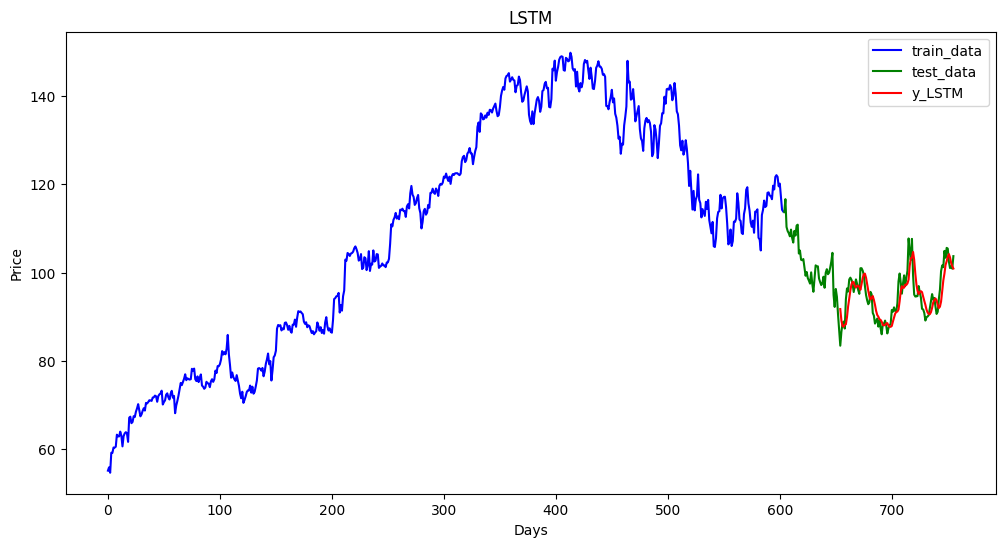

In [ ]:
plt.figure(figsize=(12, 6))

# Deuxième graphique pour LSTM
plt.plot(TRAIN_date, TRAIN_data, label="train_data", color="b")
plt.plot(TEST_date, TEST_data, label="test_data", color="g")
plt.plot(TEST_date[50:], y_LSTM_O, label="y_LSTM", color="r")

plt.legend()
plt.title("LSTM")
plt.xlabel("Days")
plt.ylabel("Price")

plt.show()


# GRU Model

In [ ]:
#Construction du modèle RNN
regressorGRU = Sequential()

## Définition de l'architecture du modele
regressorGRU.add(GRU(units=50,
					return_sequences=True,
					input_shape=(X_train.shape[1],1),
					activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50,
					return_sequences=True,
					activation='tanh'))

regressorGRU.add(GRU(units=50,
					activation='tanh'))

regressorGRU.add(Dense(units=1,
					activation='relu'))
## Compilation du modele GRU
regressorGRU.compile(optimizer = SGD(learning_rate=0.01,
								momentum=0.9,
								nesterov=True),
				loss = "mean_squared_error")

regressorGRU.fit(X_train,y_train,epochs=5,batch_size=1)
regressorGRU.summary()


Epoch 1/5
554/554 [==============================] - 20s 28ms/step - loss: 0.0088
Epoch 2/5
554/554 [==============================] - 16s 28ms/step - loss: 0.0027
Epoch 3/5
554/554 [==============================] - 16s 29ms/step - loss: 0.0025
Epoch 4/5
554/554 [==============================] - 16s 28ms/step - loss: 0.0024
Epoch 5/5
554/554 [==============================] - 16s 29ms/step - loss: 0.0024
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            7950      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50, 

 ## Validation du modele GRU

In [ ]:
lossGRU = regressorGRU.evaluate(X_test, y_test)
print(f'Loss: {lossGRU}')

4/4 [==============================] - 1s 14ms/step - loss: 0.0167
Loss: 0.016720009967684746


# Utilisation du modele GRU pour la prediction

In [ ]:
y_GRU = regressorGRU.predict(X_test)

y_GRU_O = scaler.inverse_transform(y_GRU)

4/4 [==============================] - 1s 13ms/step


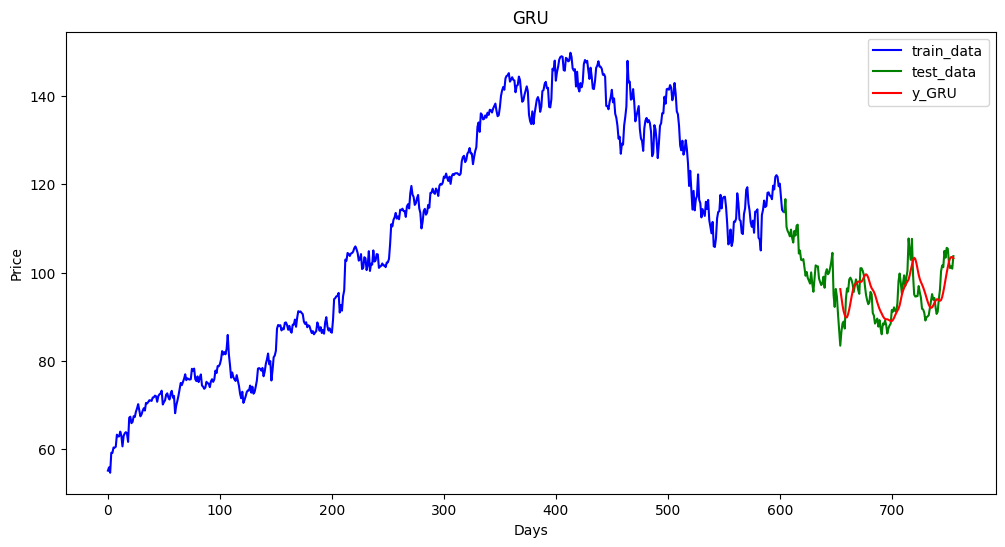

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(TRAIN_date, TRAIN_data, label="train_data", color="b")
plt.plot(TEST_date, TEST_data, label="test_data", color="g")
plt.plot(TEST_date[50:], y_GRU_O, label="y_GRU", color="r")

plt.legend()
plt.title("GRU")
plt.xlabel("Days")
plt.ylabel("Price")

plt.show()


#Comparaison entre modeles RNN, LSTM et GRU

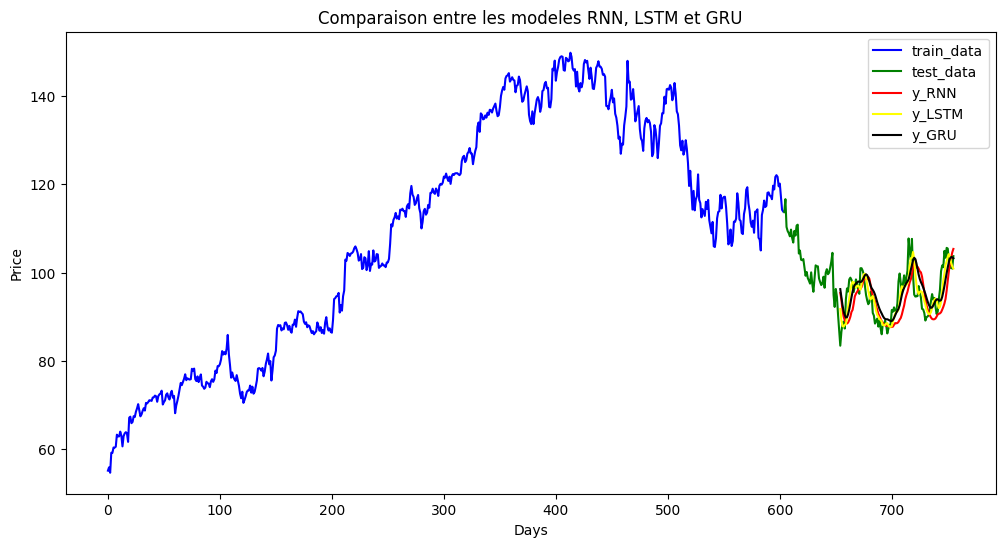

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(TRAIN_date, TRAIN_data, label="train_data", color="b")
plt.plot(TEST_date, TEST_data, label="test_data", color="g")
plt.plot(TEST_date[50:], y_RNN_O, label="y_RNN", color="r")
plt.plot(TEST_date[50:], y_LSTM_O, label="y_LSTM", color="yellow")
plt.plot(TEST_date[50:], y_GRU_O, label="y_GRU", color="black")

plt.legend()
plt.title("Comparaison entre les modeles RNN, LSTM et GRU")
plt.xlabel("Days")
plt.ylabel("Price")

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Calcul de MAE pour chaque modèle
mae_RNN = mean_absolute_error(y_test, y_RNN_O)
mae_LSTM = mean_absolute_error(y_test, y_LSTM_O)
mae_GRU = mean_absolute_error(y_test, y_GRU_O)

# Affichage des résultats
print("MAE pour RNN :", mae_RNN)
print("MAE pour LSTM :", mae_LSTM)
print("MAE pour GRU :", mae_GRU)


MAE pour RNN : 93.34131900877837
MAE pour LSTM : 94.28958797395723
MAE pour GRU : 95.0716931393266
